## Analyze A/B Test Results - Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Overall Conclusions](#conclusions)

<a id='intro'></a>
### Introduction

A/B tests are commonly performed by data analysts and data scientists.  This project involves working to understand the results of an A/B test run by an e-commerce website.  The **GOAL** is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

ADDITIONAL NOTE:  The Udacity classroom has corresponding quiz questions associated with different sections of the below Notebook.  As a final check, all the criteria that need to be met are on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

In [1]:
# Import the needed libraries.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# The seed is being set to assure that the same answers are obtained for the Udacity classroom quizzes.
random.seed(42)

#### 1. Quiz 1-associated section:

a. Read in the dataset and look at the top few rows.

In [2]:
# Read in the full A/B Test data and view the top several rows.
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

In [3]:
# Determine the number of rows in the full dataset.
print(df.info(), "\n")

# OR...
df.shape[0]

# NOTE: May want to change 'timestamp' column to datetime data type.
# df.timestamp = pd.to_datetime(df.timestamp)
#     OR
# df['timestamp'] = pd.to_datetime(df['timestamp'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None 



294478

#### Conclusion:  294478 rows in full dataset.

c. The number of unique users in the full dataset.

In [4]:
# The number of unique users in the full dataset.
df.user_id.nunique()

290584

#### Conclusion: 290584 unique users in the full dataset.

d. The proportion of unique users converted.

In [5]:
# The proportion of BOTH "control" AND "treatment" UNIQUE users that converted.
df.query('converted == 1')['user_id'].nunique() / df.user_id.nunique()

0.12104245244060237

#### Conclusion: A 0.12104 proportion (12.104%) of all unique users converted in the full dataset.

In [6]:
# ADDITIONAL NOTE (FOR MY CURIOSITY):
# Identify any users that converted more than once.
user_conversion = df.groupby('user_id')['converted'].sum()
multi_converted_users = user_conversion[user_conversion > 1]
# REM: Pandas Series name repeated, rather than giving a DataFrame 
# column name for Boolean indexing of a Pandas Series.

# Display the Series of 'user_id's of those who converted more than once.
print(multi_converted_users)

# Store and display the Series indexes (which are the 'user_id's) of those who converted more than once.
multi_converted_user_ids = multi_converted_users.index
print('\n', multi_converted_user_ids)

# Display the full DataFrame's rows associated with the multi-converted 'user_id's.
df.query('user_id in @multi_converted_user_ids')
# REM: Refer to variables in the "query" environment by prefixing them with an ‘@’ character.

user_id
634881    2
637639    2
639635    2
642866    2
657619    2
         ..
915280    2
917949    2
937901    2
943137    2
945627    2
Name: converted, Length: 64, dtype: int64

 Int64Index([634881, 637639, 639635, 642866, 657619, 669913, 678722, 684279,
            689273, 697641, 699757, 709558, 716366, 724894, 728040, 728830,
            729669, 733339, 744247, 744411, 746310, 759632, 761744, 765231,
            767964, 768265, 779906, 781019, 810257, 824233, 826424, 828302,
            832110, 833113, 833424, 838320, 841046, 844946, 847832, 851651,
            858458, 858910, 859346, 859350, 864973, 873093, 874307, 876037,
            880932, 883687, 887357, 887573, 892397, 901109, 902109, 904340,
            911590, 913537, 915090, 915280, 917949, 937901, 943137, 945627],
           dtype='int64', name='user_id')


,user_id,timestamp,group,landing_page,converted
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
3362,858458,2017-01-06 04:51:33.183576,control,new_page,1
4961,844946,2017-01-04 07:20:58.924520,treatment,old_page,1
6828,642866,2017-01-11 02:18:49.882994,treatment,old_page,1
8408,699757,2017-01-06 19:15:46.467126,treatment,old_page,1
...,...,...,...,...,...
290149,858910,2017-01-10 05:20:37.997730,treatment,old_page,1
290950,781019,2017-01-21 15:33:08.559274,treatment,new_page,1
291707,917949,2017-01-18 16:24:28.263463,treatment,new_page,1
292941,874307,2017-01-10 23:53:29.996813,treatment,new_page,1


In [7]:
# Specifically looking at the DataFrame rows for two of the previously identified 'multi_converted_user_ids'.
df.query('user_id in [634881, 637639]')

# NOTE:  Output is as one would expect.

,user_id,timestamp,group,landing_page,converted
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
106312,637639,2017-01-12 06:25:18.717847,treatment,new_page,1
170353,634881,2017-01-03 15:57:33.336873,treatment,old_page,1
193001,634881,2017-01-18 17:44:23.130122,treatment,new_page,1


In [8]:
# Just checking the total number of those who converted vs. the number of unique users who converted.
print(df.query('converted == 1').shape[0])
df.query('converted == 1')['user_id'].nunique()

# NOTE:  From above, the expected difference of 64 = 35237 - 35173 .

35237


35173

e. The number of times that `new_page` and `treatment` don't match.

In [9]:
# Number of "treatment", but not "new_page"  PLUS  Number of "control", but not "old_page".
df.query('group == "treatment" & landing_page != "new_page" ').shape[0] \
+ df.query('group == "control" & landing_page != "old_page" ').shape[0]

3893

#### Conclusion: 3893 rows of the full dataset had mismatching 'group' and 'landing_page' values.

f. Do any of the rows have missing values?

In [10]:
# In general, one can use  df.info()  to address this question as I did above
# (and found that none of the columns, and thus, none of the rows, contained NULL values).

# More specifically, return True (value of 1) for the rows with a NULL/NaN in any column of each row.
df.isnull().any(axis=1).sum()

0

#### Conclusion: None of the rows have missing values.

#### 2. Quiz 2-associated section:

a. Create a new dataset, **df2**, that no longer contains the mismatched 'group' and 'landing_page' rows (because we cannot be sure if these rows truly received the new or old page).

In [11]:
# Identify the DataFrame rows with "treatment" 'group', but not "new_page" 'landing_page'.
df_TxNotNewPage = df.query('group == "treatment" & landing_page != "new_page" ')
print(df_TxNotNewPage.shape)

# Identify the rows with "control" 'group', but not "old_page" 'landing_page'.
df_CtrlNotOldPage = df.query('group == "control" & landing_page != "old_page" ')
df_CtrlNotOldPage.shape

# NOTE: 1965 + 1928 = 3893 total rows, as expected from above.

(1965, 5)


(1928, 5)

In [12]:
# Drop the rows with "treatment", but not "new_page", and assign to df2. 
df2 = df.drop(df_TxNotNewPage.index, axis=0)    # NOTE: w/o 'inplace=True' here.

print(df.shape)   # Still 294478, as expected.
df2.shape         # NOTE:  294478 - 1965 = 292513 , as expected.

(294478, 5)


(292513, 5)

In [13]:
# Drop the rows with "control", but not "old_page", permanently from df2.
df2.drop(df_CtrlNotOldPage.index, axis=0, inplace=True)

df2.shape         # NOTE:  292513 - 1928 = 290585 , as expected.

(290585, 5)

In [14]:
# UDACITY:  Double Check that all the correct ("treatment" but not "new_page")
# rows were removed;  this should be 0.
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) \
    == False].shape[0]

0

In [15]:
# Double Check that all the correct ("control" but not "old_page")
# rows were removed;  this should be 0.
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) \
    == False].shape[0]

0

#### Conclusion: All of the mismatched 'group' and 'landing_page' rows appear to have been dropped correctly from df2.

#### 3. Quiz 3-associated section:
a. How many unique **user_id**s are in **df2**?

In [16]:
# Number of unique 'user_id's in df2.
df2.user_id.nunique()

290584

#### Conclusion: 290584 unique users in df2.

b. What is the one **user_id** repeated in **df2**?

In [17]:
# value_counts based on user_id values.
df2_user_id_valct = df2.user_id.value_counts()
print(df2_user_id_valct) 

# Boolean indexing of a Pandas Series of "value_counts".
df2_user_id_valct[df2_user_id_valct > 1]

# NOTE:  Alternative approaches include the use of  df2.user_id.duplicated()  
#        OR  df2.groupby('user_id') [perhaps with a .filter() method w/ a lambda function argument?])

773192    2
630732    1
811737    1
797392    1
795345    1
         ..
650647    1
648598    1
654741    1
652692    1
630836    1
Name: user_id, Length: 290584, dtype: int64


773192    2
Name: user_id, dtype: int64

#### Conclusion:  The repeated 'user_id' in df2 is 773192.

c. What is the row information for the repeat **user_id**? 

In [18]:
# Indexes (in this case, user_ids) of Repeated user_id rows.
dup_user_id_valct = df2_user_id_valct[df2_user_id_valct > 1].index
print(dup_user_id_valct)

# Display rows with repeated user_ids.
df2.query('user_id in @dup_user_id_valct')

Int64Index([773192], dtype='int64')


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [19]:
# Drop the row(s) having a repeated 'user_id' value.
df2.drop_duplicates(subset=['user_id'], inplace=True)

print(df2.shape)   # Should be 290584, 5

# Re-display the rows with previously repeated user_ids.
df2.query('user_id in @dup_user_id_valct')

(290584, 5)


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


#### Conclusion: The one row with a repeated user_id has been dropped from df2.

#### 4. Quiz 4-associated section:

a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
# Rechecking df2 for total number of rows, uniqueness of all user_ids, and 
# data types of each column (timestamp still not "datetime" data type).
print(df2.info(), '\n')
print(df2.user_id.nunique())
df2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB
None 

290584


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [21]:
# Probability of individual converting regardless of landing_page type.
df2.converted.mean()

0.11959708724499628

#### Conclusion: A 0.119597 proportion (11.9597%) of unique users converted regardless of 'landing_page' in the df2 dataset.

b. Given that an individual was in the `control` group, what is the probability they converted?

In [22]:
# Probability of "control" individual converting.
print(df2.query('group == "control"')['converted'].value_counts())  # pre-check.

df2.query('group == "control"')['converted'].mean()

0    127785
1     17489
Name: converted, dtype: int64


0.1203863045004612

#### Conclusion: A 0.120386 proportion (12.0386%) of unique "control" ("old_page") users converted in the df2 dataset.

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [23]:
# Probability of 'treatment' individual converting.
print(df2.query('group == "treatment"')['converted'].value_counts())  # pre-check.

df2.query('group == "treatment"')['converted'].mean()

0    128046
1     17264
Name: converted, dtype: int64


0.11880806551510564

#### Conclusion: A 0.118808 proportion (11.8808%) of unique "treatment" ("new_page") users converted in the df2 dataset.

d. What is the probability that an individual received the new page?

In [24]:
# Probability of an individual "landing on" the new_page.
(df2.landing_page == "new_page").mean()
# REM: Within the parentheses, each row of the designated column evaluates as True or False 
# and they evaluate as 1 or 0, respectively.

0.5000619442226688

#### Conclusion:  There is a 50% chance of an individual landing on the new page.

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The conversion rate for the "treatment/new_page" group was less than that for the "control/old_page" group, and the number of individuals in each of the two groups is sufficiently large to avoid unexpected large changes in proportion values with any individual change in conversion.  Thus, from this data and analysis, there is no indication that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

#### 1. Hypotheses:
Based on all of the df2 data and under the assumption that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the Null and Alternative hypotheses be (**$p_{old}$** and **$p_{new}$** are the converted rates for the old and new pages, respectively)?

>**Null hypothesis, H0: $p_{new}$ - $p_{old}$ <= 0**
    i.e., π\_𝑛𝑒𝑤 - π\_𝑜𝑙𝑑 <= 0

>**Alternative hypothesis, H1: $p_{new}$ - $p_{old}$ > 0**
  i.e., π\_𝑛𝑒𝑤 - π\_𝑜𝑙𝑑 > 0

#### 2. Quiz 5-associated section and "Simulated" and "Traditional" p-value calculations:
NOTE: I found the Udacity instructions for this section somewhat confusing, as indicated in my 'comments' (#) below.

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [25]:
# NOTE:  I assume that the cleaned-up df2 dataset should be used here rather than
# the full, starting "ab_data.csv" (as stated in the instructions) dataset, correct?

# So, IF I UNDERSTOOD THE UDACITY INSTRUCTIONS CORRECTLY,
# "p_new under the null" is considered here to be the "converted rate" 
# for the treatment/new_page individuals REGARDLESS OF THE PAGE, which is...
p_new_true = df2.converted.mean()
p_new_true

0.11959708724499628

In [26]:
# More generally, p_new would be calculated as follows:
p_new = df2.query('group == "treatment"').converted.mean()

# And this particular p_new would be what I refer to as the "observed 
# p_new" (which I think corresponds to Udacity's "actual" in j. below 
# as opposed to Udacity's "true" p_new above, correct?)
p_new_obs = p_new
p_new_obs

0.11880806551510564

#### Conclusions: 
- The conversion rate for p_new under the null, p_new_true, is 0.119597 (11.9597%).
- The "observed" conversion rate for the "treatment/new_page" group in df2, p_new_obs, is 0.118808 (11.8808%).

b. What is the **conversion rate** for $p_{old}$ under the null?

In [27]:
# Udacity also stated to assume that "p_old under the null" is the 
# "converted rate" for the control/old_page individuals REGARDLESS
# OF PAGE, which is...
p_old_true = df2.converted.mean()
p_old_true

0.11959708724499628

In [28]:
# More generally, p_old would be calculated as follows:
p_old = df2.query('group == "control"').converted.mean()

# And this particular p_old would be what I refer to as the "observed 
# p_old" (which I think is Udacity's "actual" p_old below as opposed
# to Udacity's "true" p_old above, correct?)
p_old_obs = p_old
p_old_obs

0.1203863045004612

#### Conclusions: 
- The conversion rate for p_old under the null, p_old_true, is 0.119597 (11.9597%).
- The "observed" conversion rate for the "control/old_page" group in df2, p_old_obs, is 0.120386 (12.0386%).

c. What is $n_{new}$, the number of individuals in the treatment group?

In [29]:
# Number of "treatment" group individuals (REM: only unique user_ids in df2).
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

#### Conclusion: The number of "treatment" group individuals, n_new, is 145310.

d. What is $n_{old}$, the number of individuals in the control group?

In [30]:
# Number of "control" group individuals (REM: only unique user_ids in df2).
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

#### Conclusion: The number of "control" group individuals, n_old, is 145274.

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [31]:
# Starting "treatment" rows from df2.
treatment_df = df2.query('group == "treatment"')

# My understanding here is that Udacity is looking for a single Bootstrapped
# "treatment" resample, correct?
treatment_bootsample = treatment_df.sample(n_new, replace=True)
new_page_converted = treatment_bootsample.converted

print(new_page_converted.shape)   # Just a check.

p_new_sample = new_page_converted.mean()
p_new_sample

(145310,)


0.11797536301699814

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [32]:
# Starting "control" rows from df2.
control_df = df2.query('group == "control"')

# My understanding here is that Udacity is looking for a single Bootstrapped
# "control" resample, correct?
control_bootsample = control_df.sample(n_old, replace=True)
old_page_converted = control_bootsample.converted

print(old_page_converted.shape)   # Just a check.

p_old_sample = old_page_converted.mean()
p_old_sample

(145274,)


0.12163910954472239

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [33]:
# The difference between the resampled treatment/new_page converted rate
# and the resampled control/old_page converted rate.
p_diff = p_new_sample - p_old_sample
p_diff

-0.0036637465277242487

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [34]:
# NumPy array to store Bootstrapped p_diff values.
p_diffs = np.array([])

for i in range(0, 10000):
    # new_page converted probability/proportion.
    treatment_bootsample = treatment_df.sample(n_new, replace=True)
    new_page_converted = treatment_bootsample.converted
    p_new_sample = new_page_converted.mean()
    
    # old_page converted probability/proportion.
    control_bootsample = control_df.sample(n_old, replace=True)
    old_page_converted = control_bootsample.converted
    p_old_sample = old_page_converted.mean()
    
    # Difference between probability of new_page converted and 
    # old_page converted.
    p_diff = p_new_sample - p_old_sample
    
    # Storage of each p_diff value in p_diffs NumPy array.
    p_diffs = np.append(p_diffs, p_diff)

p_diffs

array([-0.00108284, -0.00165389, -0.0017299 , ..., -0.00115841,
       -0.00233525, -0.00201884])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  

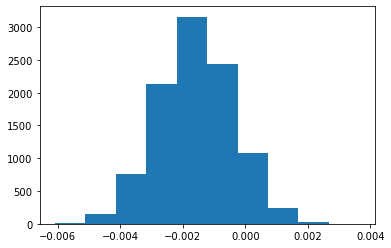

In [35]:
# Plot the distribution of the statistic of interest, i.e., p-diff.
plt.hist(p_diffs);

#### Conclusion: As expected for a difference in proportions, the distribution of this statistic appears to be "Normal" in shape.  Thus, we can create a Normal distribution to "Simulate from the Null" and then assess the probability of the observed p_diff statistic value with respect to the Null Space.

j. What proportion of the **p_diffs** are greater than the actual (observed) difference observed in **ab_data.csv (i.e., df2)**?

In [36]:
# ADDITIONAL NOTE (FOR MY CURIOSITY):  Here, I am taking the "actual difference observed in 
# ab_data.csv" as still referring to the assumed Null hypothesis
# difference of zero (0).  THIS IS NOT HOW WE HAVE DONE THIS IN THE PAST,
# but I am interested in this value and how it compares to the calculated p-value further below.
(p_diffs > 0).mean()

# NOTE: This value, at least in this instance, does appear to be 
# quite close to  1 - (p-value) , with "p-value" as calculated below.

0.0939

-0.0015782389853555567


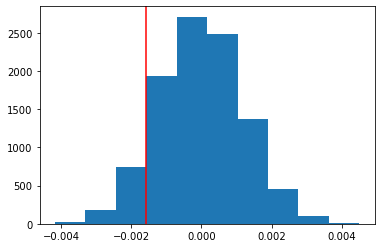

In [37]:
# Create distribution under the Null hypothesis (i.e., Simulate from
# the Null).
null_vals = np.random.normal(loc=0, scale=p_diffs.std(), size=p_diffs.size)

# Calculate the actual/observed difference, p_diff_obs, from above p_new_obs and p_old_obs.
p_diff_obs = p_new_obs - p_old_obs
print(p_diff_obs)

# Histogram of the Simulated Null Space with a vertical line for the
# observed difference in converted rate for the new page vs. the old page.
plt.hist(null_vals);
plt.axvline(x=p_diff_obs, color='red');

In [38]:
# p-value calculation of the observed difference in
# converted rate for the new page vs. the old page.
(null_vals > p_diff_obs).mean()

0.9051

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value calculated in part j. is the _p-value_ of the observed sample statistic, p_diff_obs (-0.001578).  This p-value (~0.90) is the probability of observing this statistic value or one more extreme in favor of (i.e., toward) the Alternative Hypothesis, given that the Null Hypothesis is true.**

**Thus, the very high probability (~0.90) of observing this statistic value indicates that the Null Hypothesis should be retained.  That is, we cannot conclude from this data that the new page is significantly more likely to have a higher "converted rate" than the old page.**

l. Use a "traditional" built-in (closed-form) function to achieve similar results to the above "Simulating from the Null" approach, the latter of which is critical to correctly think about statistical significance. 

In [39]:
import statsmodels.api as sm

# Determine the number of conversions for "control/old_page" and for "treatment/new_page".
convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()

# Determine the number of rows associated with "control/old_page" and "treatment/new_page".
n_old = df2.query('group == "control"').user_id.count()
n_new = df2.query('group == "treatment"').user_id.count()

print(convert_old)
print(convert_new)
print(n_old)
print(n_new)

17489
17264
145274
145310


m. Now use `stats.proportions_ztest` to compute the test statistic and p-value from the "single" starting (non-resampled) df2 dataset.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using this statsmodels built-in function.

In [40]:
# Difference in Two (Large Sample) Proportions Z-test.
counts = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])
# NOTE: 'counts' and 'nobs' ordered above so that p_new is "p1" and
# p_old is "p2" with respect to the stats.proportions_ztest function. 

stat, pval = sm.stats.proportions_ztest(counts, nobs, value=0, alternative='larger')
# NOTE: 'larger' indicates that the Alternative Hypothesis is p1 > p2, i.e.,
# p_new - p_old > 0, as indicated above for H1.

stat, pval

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score (-1.3109) is calculated by dividing the difference between the two sample proportions, i.e., p_new - p_old, by the appropriate Standard Error [(Stat Trek)](https://stattrek.com/hypothesis-test/difference-in-proportions.aspx?tutorial=AP). This z-score represents the "standardized" distance from (i.e., "to the left of", because negative) the central value, 0, of a Normal-shaped distribution curve, and it is derived from the non-standardized p\_diff\_obs value (-0.001578) above.**

**From a Probability Table for the Standard Normal Distribution, a z-score of -1.3109 indicates a probability area of just over 0.40 from the observed z-score to the central value (i.e., toward H1, because p\_new _greater than_ p\_old). Adding this to the 0.50 probability area to the right of the central value (i.e., again, _greater than_), one ends up with a probability of ~0.90 (90%) that the observed statistic or one more extreme toward H1 would occur under the Null Hypothesis (i.e., would fall within the theoretical Null Space).**

**Thus, both the "traditional" z-score and its associated p-value are in agreement with the "simulated" findings in parts j. and k.**

<a id='regression'></a>
### Part III - A regression approach

#### 1. Regression approach to obtain a similar result to that in the A/B Test, Part II (above).<br>

a. Since each row is either a conversion or no conversion, what type of regression should be performed in this case?

**Logistic Regression should be performed in this case because the 'converted' response(y)-variable values are binary categorical (0 or 1), rather than quantitative, in nature.**

b. Use **statsmodels** to fit a Logistic Regression model to see if there is a significant difference in conversion based on which page a customer receives.

In [41]:
# Add necessary columns to the DataFrame:

# (1) Add an 'intercept' column.
df2['intercept'] = 1

# (2) Convert the 'converted' binary categorical response(y) variable
# values to  0s and 1s using .getdummies(), if needed.
# NOTE: Already 0s and 1s for non-converted and converted, respectively.

# (3) Generate dummy variable columns from categorical explanatory(x)
# column(s) using .getdummies(). 
# In this case, the only explanatory variable being considered is the 'landing_page', 
# and we want the "treatment" individuals to be coded as 1s and "control" individuals as 0s.
# REM: Output is in alphabetical order of the column values.
df2[['control_page', 'ab_page']] = pd.get_dummies(df2['group'])

# (4) Generate higher-order explanatory(x) term columns, if desired.
# NOTE: Not applicable here.

# Drop extra column(s), if desired.
df2 = df2.drop('control_page', axis=1)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate (set up) and fit a Logistic Regression model based on the 'converted' response(y)-variable column and all but one (the "baseline") of the categorical explanatory(x)-variable dummy columns (along with the 'intercept' column) to predict whether or not an individual converts.

In [42]:
# Set up the Logistic Regression model.
logit_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

# Fit the model.
results = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [43]:
# Summary of the model fit results.
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 31 Mar 2021   Pseudo R-squ.:               8.077e-06
Time:                        13:16:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

**The p-value associated with 'ab_page' is 0.190.**

**For the regression model, the calculated p-value is a "two-sided" p-value, rather than the "one-sided" p-value of the Part II A/B Test.  That is, the regression model is based on a Null Hypothesis (H0) of  p_new - p_old = 0  and an Alternative Hypothesis (H1) of  p_new - p_old != 0.  Thus, with the regression model, when we ask "What is the probability of the observed statistic or one more extreme toward H1, given that the Null Hypothesis is true?", we assess the area-under-the-curve further away than the z-score _in either direction_ (i.e., < -1.311 or > +1.311 standardized units) from the central value, 0, of the Standard Normal Distribution.  So, in this case, the Probability Table of the Standard Normal Distribution indicates that the "more extreme" areas associated with a z-score of |-1.311| are (2)(0.095) = 0.190 .**

In [44]:
# ADDITIONAL NOTE (FOR MY CURIOSITY): "Exponentiate" the explanatory(x) variable coefficient(s) to determine... 
# "the number of times as likely the 'treatment/new_page(1)' is to 'convert' 
# (i.e., odds of a '1' value) compared to the 'control/old_page(0)' (i.e., the "Baseline",
# which corresponds to the Dummy variable that was dropped in the regression model set up).
np.exp(-0.015)

# NOTE: So, 0.985 indicates that it is slightly less likely to 'convert' with the new_page
# compared to the old_page, which is consistent with p_diff_obs (-0.001578) further above.

0.9851119396030626

f. With respect to considering other things that might influence whether or not an individual converts, discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**A/B Testing and the preceding ab_page-only regression model essentially focused on an "aggregated" (overall) assessment of whether the new page led to a greater converted rate than the old page, so these approaches do not address what other "features" might contribute to an individual deciding to convert.  Thus, by considering other factors/features in the modeling, one may be able to begin to identify additional underlying factors contributing to an individual converting.**

**In general, adding additional features to a model may improve fitting; however, a disadvantage of doing this (particularly with higher-order features) is that interpretation of the results can become more difficult.  In addition, one needs to keep in mind that even if a particular feature does appear to correlate with converting, this may be an indirect effect (i.e., "correlation does not mean causation").**

g. Now, along with testing if the conversion rate changes for different landing pages, also add an effect based on which country a user lives in (see [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) for how to join the **countries.csv** dataset with df2 based on the appropriate column(s) values). Does it appear that country had an impact on conversion?

In [45]:
# Read in countries.csv data, and check on the column names and number of rows.
country_df = pd.read_csv('countries.csv')

print(country_df.info())
country_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB
None


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [46]:
# Join/Merge df2 and country_df based on 'user_id'.
df3 = df2.join(country_df.set_index('user_id'), on='user_id')

df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [47]:
# Check that the expected country was aligned based on 'user_id'.

# First five 'user_id' values from country_df above.
ids = country_df.user_id.values[0:5]
print(ids)

df3.query('user_id in @ids')

# NOTE: Looks correct, UK for all but user_id 928468.

[834778 928468 822059 711597 710616]


,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
48778,711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,UK
106686,710616,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,UK
143206,834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,UK
157345,928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,US
257177,822059,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,UK


In [48]:
# Unique values in the 'country' column.
country_df.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [49]:
# Generate dummy variable columns from the 'country' column and add to df3.
# REM: Output is in alphabetical order of the column values.
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])

df3.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [50]:
# Set up Logistic Regression model.
# REM: Drop one of each explanatory(x)-variable dummy columns.
logit_model = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK']])
# REM: "Baseline" for 'ab-page' is old_page and for the three countries it is US, as set up here.

# Fit and Summarize model.
results = logit_model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 31 Mar 2021   Pseudo R-squ.:               2.323e-05
Time:                        13:16:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [51]:
# For comparison, set up a second Logistic Regression model with CA (Canada) as the 'country' baseline.
logit_model = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK', 'US']])
# REM: "Baseline" for 'ab-page' is old_page and for the three countries it is CA (Canada), as set up here.

# Fit and Summarize model.
results = logit_model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 31 Mar 2021   Pseudo R-squ.:               2.323e-05
Time:                        13:16:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [52]:
# ADDITIONAL NOTE (FOR MY CURIOSITY): "Exponentiate" the explanatory(x) variable coefficient(s) to determine... 
# "the number of times as likely UK or US individuals are to 'convert' 
# (i.e., odds of a '1' value) compared to CA individuals (i.e., the "Baseline",
# which corresponds to the Dummy variable that was dropped in the regression model set up).
np.exp(0.0506), np.exp(0.0408)

(1.0519020483004984, 1.0416437559600236)

In [53]:
# Converted rates for control/old_page and treatment/new_page groups based on country
# for comparison to the preceding Logit Regression results.
df3.groupby(['group', 'country'])['converted'].mean()

group      country
control    CA         0.118783
           UK         0.120022
           US         0.120630
treatment  CA         0.111902
           UK         0.121171
           US         0.118466
Name: converted, dtype: float64

**QUESTION:  Does it appear that country had an impact on conversion?**

**In the (second) modeling that includes 'country', the p-values 0.074 and 0.130 respectively correspond to the probability of conversion in the UK and US compared to the "baseline", CA. These two-sided p-values do not quite meet the typical 0.05 alpha level of significance, but the data is suggestive of a higher converted rate in the UK (with a statistically significant p-value under the appropriate one-sided hypotheses), and perhaps in the US, compared to CA.**

h. Having looked at the individual factors of country and landing page on conversion, now look at an "Interaction" between page and country to see if there are significant effects on conversion. 

In [54]:
# Generate new "Interaction" columns.
# NOTE: My understanding is that I will need to multiply the 'ab_page' 
# by each of the 'CA', 'UK', and 'US' columns and then include
# two of these three interaction terms in the model set up.
df3['page_CA'] = df3['ab_page']*df3['CA']
df3['page_UK'] = df3['ab_page']*df3['UK']
df3['page_US'] = df3['ab_page']*df3['US']

df3.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,page_CA,page_UK,page_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1,0,0,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1,0,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0,1,0,0


In [55]:
# Set up Logistic Regression model with both the respective lower-order and higher-order terms.
logit_model = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK', 'page_CA', 'page_UK']])
# REM: "Baseline" for 'ab-page' is old_page and for the three countries it is US, as set up here.

# Fit and Summarize model.
results = logit_model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 Mar 2021   Pseudo R-squ.:               3.482e-05
Time:                        13:16:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
page_CA       -0.0469      0.054     -0.872      0.383      -0.152       0.059
page_UK        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

In [56]:
# Set up Logistic Regression model with both the respective lower-order and higher-order terms.
logit_model = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK', 'US', 'page_UK', 'page_US']])
# REM: "Baseline" for 'ab-page' is old_page and for the three countries it is CA (Canada), as set up here.

# Fit and Summarize model.
results = logit_model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 Mar 2021   Pseudo R-squ.:               3.482e-05
Time:                        13:16:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
page_UK        0.0783      0.057      1.378      0.168      -0.033       0.190
page_US        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

#### Conclusion:
**If I have correctly set up the preceding "interaction" models, none of the p-values associated with the explanatory(x) variable terms showed a significant influence on conversion rate.  In essence, with the interaction terms we are assessing whether "The way that the 'ab_page' (new_page vs. old_page) is related to the conversion rate is dependent on the 'country' (CA, UK, US) value."  Thus, these "interaction" models do not appear to argue in favor of a meaningful interaction between the country and the ab_page with respect to conversion rate.**

<a id='conclusions'></a>
## Overall Conclusions:
1. Potential minor, statistically significant increase in conversion rate in UK compared to CA.
2. No other analyses (A/B Test of new page vs. old page or Logistic Regression modeling with explanatory variables of only new page vs. old page or with higher-order interaction terms) indicated any statistically significant difference in conversion rate associated with the landing page, country, or an interaction between these two.
3. With respect to practical significance, the tenths of a percent and mixed direction (some positive, but mostly negative) fluctuations in conversion rates associated with the new page argue against implementing the new page.

### In summary, neither statistical nor practical considerations favor implementation of the new web page.